<a href="https://colab.research.google.com/github/cdelcastillo21/ml/blob/master/NeuralDensityEstimators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Density Estimators 
CSE 392 Fall 2019 - Final Project \
Carlos del-Castillo-Negrete







## Overview
The following workbook implements a normalized flow for density estimation using a tenserflow probability TransformedDistribution composed of a chain of MaskedAutoregressiveFlow bijectors. 

## Setup

### Version Check
This notebook works with tensorflow version 2.0.0 and tensorflow probability version 0.8.0. Note in particular that by default Google colab does not load tensorflow 2.0.0, but the below code should install if it hasn't been installed already. Also note that if anything had to be installed the first time this notebook is run, you'll have to restart your runtime in order for the new versions to actually take effect. 

In [1]:
# Try to use tensorflow 2.x if available
try:
  %tensorflow_version 2.x
except Exception:
  # Install if not available
  !pip install tensorflow-gpu==2.0.0-rc0
# Install latest version of tensorflow-probability
!pip install tensorflow-probability==0.8.0-rc0

TensorFlow 2.x selected.


### Libraries
Verify that the printed version statements match the versions in the section above. 

In [0]:
# Plotting and utilities
import numpy as np
from time import time
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf                  
import tensorflow_probability as tfp

# Libraries for toy data sets
from sklearn import cluster, datasets, mixture    
from sklearn.preprocessing import StandardScaler

In [3]:
# Verify Veersion
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

tfd = tfp.distributions
tfb = tfp.bijectors

TFP Version 0.8.0-rc0
TF  Version 2.0.0


### Parameters
Defined here are the default parameters for setting up the data, normalizing flow, and training loop. 

In [0]:
# Fix random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Datatypes to use throughout
DTYPE = tf.float32
NP_DTYPE = np.float32

In [0]:
DEFAULT_NUM_STEPS = 1000    # Number of total training iterations
DEFAULT_INTERVAL = 100      # Iteration intervals to print/collect stats
DEFAULT_NUM_DATA = 10000    # Number of data points to generate from datasets
DEFAULT_BATCH_SIZE = 1000   # Training batch size
DEFAULT_NUM_PAD = 0         # Number of zeros to pad input with
DEFAULT_NUM_BIJECTORS = 4   # Number of bijectors to use in flow
DEFAULT_BATCH_NORM = False  # Whether to use Batch Normalization by default

## Datasets
This section defines three different 2D data sets that our normalizing flow will try to build a density function for.

### Building Tensorflow Dataset for Training
First we need a method to preprocess our data into iterable batches that can be called on demand during training. Tensorflow's Dataset type provides methods for building batched, shuffled, and even padded data sets.

In [0]:
# Function for building padded data set in training batches
def build_dataset_iterator(data, labels=None, pad=DEFAULT_NUM_PAD, 
                           batch_size=DEFAULT_BATCH_SIZE):
  if labels is None:
    # Convert to Dataset type from Numpy array
    ds = tf.data.Dataset.from_tensor_slices(data.astype(NP_DTYPE))

    # Create arbitrarily large dataset by repeating
    ds = ds.repeat()
    
    # Instruct training methods to pre-fetch data per training iteration
    ds = ds.prefetch(3 * batch_size)
    
    # Pad each element with zeros if we must amplify input dimensinon and batch
    ds = ds.padded_batch(batch_size, [2+pad])
  else:
    # Convert to Dataset type from Numpy array
    ds = tf.data.Dataset.from_tensor_slices((data.astype(NP_DTYPE),
                                             labels.astype(NP_DTYPE)))
    
    # Create arbitrarily large dataset by repeating
    ds = ds.repeat()
    
    # Instruct training methods to pre-fetch data per training iteration
    ds = ds.prefetch(3 * batch_size)
    
    # Pad each element with zeros if we must amplify input dimensinon and batch
    ds = ds.batch(batch_size)

  # Return iterator that returns next batch of training/testing data  
  return ds.__iter__()

### Dataset 1 - Uniform Distribution
The first data set is just a simple 2D uniform distribution in the range $[-1,1]$ in each dimension.


In [0]:
def gen_uniform_data(num, plot=False):
  X = np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') 
  if plot:
    xlim, ylim = [-2, 2], [-2, 2]
    plt.scatter(X[:, 0], X[:, 1], s=5, color='red')
  print("Type = ", X.dtype, " Shape = ", X.shape)
  return X

Type =  float32  Shape =  (10000, 2)


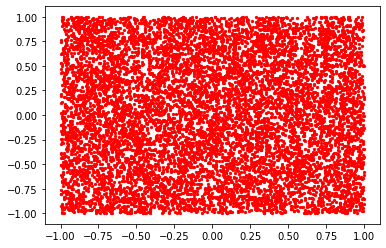

In [8]:
uniform_data = gen_uniform_data(10000, plot=True)
uniform_data_iterator = build_dataset_iterator(uniform_data)

###  Dataset 2 - Coupled Gaussian
Second target distribution is given by the product of coupled gaussian distributions. 

$p(x_1,x_2)=\mathcal{N}\left(x_1|\mu=\frac{x_2^2}{4},\sigma_1\right)\cdot\mathcal{N}\left(x_2|\mu,\sigma_2\right)$

In [0]:
def gen_cg(num, plot=False, mu=0., sigmas=[1., 4.]):
  x2_dist = tfd.Normal(loc=mu, scale=sigmas[1])
  x2_samples = x2_dist.sample(num)
  x1 = tfd.Normal(loc=0.25*tf.square(x2_samples),
                  scale=tf.fill(x2_samples.get_shape(), sigmas[0]))
  x1_samples = x1.sample()
  x_samples = tf.stack([x1_samples, x2_samples], axis=1)
  np_samples = x_samples.numpy()
  if plot:
    plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
  return np_samples

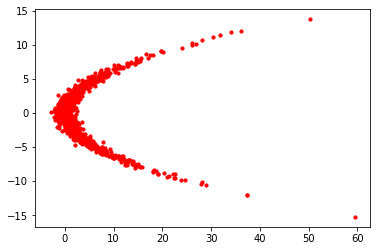

In [10]:
cg_data = gen_cg(1000, plot=True)
cg_data_iterator = build_dataset_iterator(cg_data)

### Dataset 3 - Two Moons Distribution
The third data set consisting of two overlapping crescent moon clusters. 

In [0]:
def gen_moons_data(num, plot=False):
  n_samples = 1000
  noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
  X_moon, _ = noisy_moons
  X_moon = StandardScaler().fit_transform(X_moon)
  if plot: 
    xlim, ylim = [-2, 2], [-2, 2]
    plt.scatter(X_moon[:, 0], X_moon[:, 1], s=5, color='red')
    plt.xlim(xlim)
    plt.ylim(ylim)
    print("Type = ", X_moon.dtype, " Shape = ", X_moon.shape)
  return X_moon

Type =  float64  Shape =  (1000, 2)


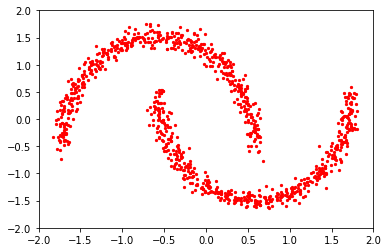

In [12]:
moons_data = gen_moons_data(10000, plot=True)
moons_data_iterator = build_dataset_iterator(moons_data)

## InvertibleFlow Class
The InvertibleFlow classes extends the tensorflow keras Model class and implements through its attribute self.flow() a transformed distribution with a sequence of bijectors. Things to note:
*   Permute and Batch normalization layers are added per layer. 
*   The call function that implements the predict feature of the model can be run in inverse or forward mode with the same network. 
*   Technically no layers exist in this Model, but trainable_variables and weights exist in the flow constructed that can be trained on. 

In [0]:
class InvertibleFlow(tf.keras.models.Model):
    def __init__(self, model='MAF', input_shape=[2], 
                 num_bijectors=DEFAULT_NUM_BIJECTORS, 
                 batch_norm=False, hidden_layers=[128,128], **kwargs): 
        super().__init__(**kwargs)

        # Accumulate list of bijectors and shift and log scale functions 
        # used at each layer
        bijectors=[]      
        self.shift_and_log_scale_fns = [] 
        flat_size=np.prod(input_shape)

        # Generate permutation.
        if input_shape == [2]:
          perm = [1, 0] 
        else:
          perm = np.random.permutation(flat_size).astype("int32")

        # print("Permutation  = ", perm)
        for i in range(num_bijectors):
          if model == 'NVP':
            # Dense layers for shift and log scale functions
            self.shift_and_log_scale_fns.append(tfb.real_nvp_default_template(
                hidden_layers=hidden_layers))
            # Affine Coupling Layer 
            bijectors.append(tfb.RealNVP(num_masked=1,
                        shift_and_log_scale_fn=self.shift_and_log_scale_fns[i]))
          elif model == 'MAF':
            self.shift_and_log_scale_fns.append(
                tfb.masked_autoregressive_default_template(
                    hidden_layers=hidden_layers))
            bijectors.append(tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=self.shift_and_log_scale_fns[i]))
          elif model == 'IAF':
            self.shift_and_log_scale_fns.append(
                tfb.masked_autoregressive_default_template(
                    hidden_layers=hidden_layers))
            bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=self.shift_and_log_scale_fns[i])))  
      
          # Permutation layer
          bijectors.append(tfb.Permute(permutation=perm))

          # Batch normalization
          if batch_norm:
            if i % 2 == 0 and i != num_bijectors:
              bijectors.append(tfb.BatchNormalization())

        # Discard the last Permute layer, reverse and chain the flow. 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        # Define the flow
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=tf.zeros(input_shape)),
            bijector=bijector)

    # Call can be for forward or inverse pass through network. 
    def call(self, x, inverse=False, training=False):
      if inverse:
        x = self.flow.bijector.inverse(x)
      else:
        x = self.flow.bijector.forward(x)
      return x

In [14]:
# Create a test flow for 2D Density Estimation
test_flow = InvertibleFlow()

# Initialize flow by building it with a test tensor
_ = test_flow(tf.constant([0., 0.]))

# See trainable parameters 
# Note how technically no layers in Keras model built.
test_flow.summary()

Instructions for updating:
Please use `layer.__call__` method instead.
Model: "invertible_flow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 69,648
Trainable params: 69,648
Non-trainable params: 0
_________________________________________________________________


##Visualizing Flow Layers
Flows can be visualized by plotting how each layer transforms a set of sample points. To help visualize where points end up, the sample points can be colored according to what quadrant they originally were in when sampled. The following function plots each flow and will help see how the flow shapes a known distribution to the target one after training. 

In [0]:
def visualize_flow(flow, num_samples=1000):
  # Generate samples 
  x = flow.distribution.sample(1000)
  
  # Accumulate how they are transformed by each layer
  samples = []
  names = [flow.distribution.name]
  for bijector in reversed(flow.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)
  
  f, arr = plt.subplots(1, len(samples), figsize=(4 * (len(samples)), 4))
  X0 = samples[0].numpy()
  for i in range(len(samples)):
    X1 = samples[i].numpy()
    # First Quadrant - Red 
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    # Second Quadrant - Blue 
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    # Third Quadrant - Green
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    # Fourth Quadrant - Black
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_title(names[i])
  return arr

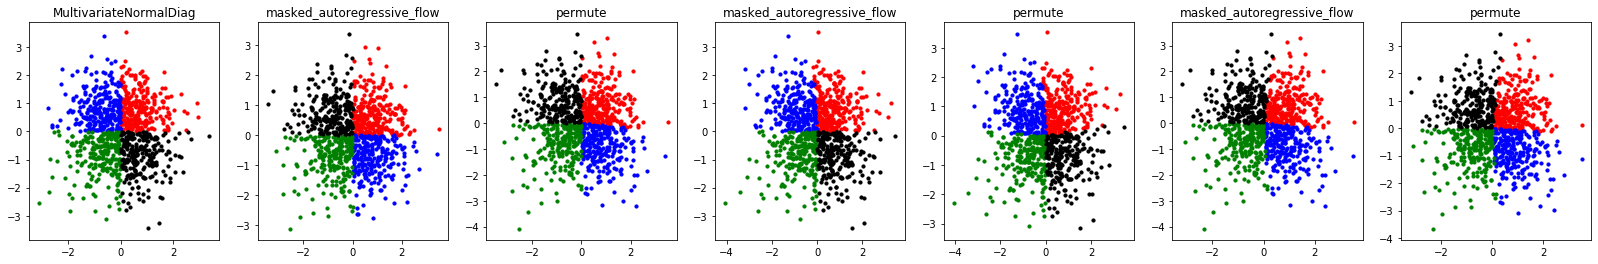

In [16]:
# Visualize untrained flow
_ = visualize_flow(test_flow.flow)

## Training the Normalizing Flow
We train the normalizing flow by maximizing the log probability of the training samples using the built in keras Adam optimizer.

In [0]:
def train_flow(model, data_iterator, iterations=DEFAULT_NUM_STEPS, 
               interval=DEFAULT_INTERVAL, progress=True):
  # Use Adam Method - A Stochastic Optimizer 
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  @tf.function #Adding the tf.function makes it about 10 times faster!!!
  def train_step(X): 
    with tf.GradientTape() as tape:
      # Maximize log prob is minimize negative of it. 
      loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
  
  # Accumulate losses and training times
  ts = []         
  losses = []
  start = time()

  # Main training loop
  for i in range(iterations):
    # Perform training step on batch of data
    loss = train_step(data_iterator.get_next())
    losses.append(loss)
    if (i % interval == 0):
      now = time()
      ts.append(now-start)
      if progress:
        print("Iter ", i, " - ", "loss = ",loss.numpy(), " avg_iter_time = ", 
              (now-start)/interval, " total_time =  ",np.sum(ts))
      start = time()
  return [losses, ts]

In [18]:
losses, ts = train_flow(test_flow, uniform_data_iterator)

Iter  0  -  loss =  2.222395  avg_iter_time =  0.021884849071502687  total_time =   2.1884849071502686
Iter  100  -  loss =  1.739863  avg_iter_time =  0.02882011413574219  total_time =   5.070496320724487
Iter  200  -  loss =  1.545208  avg_iter_time =  0.02860729694366455  total_time =   7.931226015090942
Iter  300  -  loss =  1.4923041  avg_iter_time =  0.02861678123474121  total_time =   10.792904138565063
Iter  400  -  loss =  1.464315  avg_iter_time =  0.02885387182235718  total_time =   13.678291320800781
Iter  500  -  loss =  1.4477835  avg_iter_time =  0.029110736846923828  total_time =   16.589365005493164
Iter  600  -  loss =  1.4679177  avg_iter_time =  0.028597800731658934  total_time =   19.449145078659058
Iter  700  -  loss =  1.4403833  avg_iter_time =  0.028832454681396485  total_time =   22.332390546798706
Iter  800  -  loss =  1.4427816  avg_iter_time =  0.029091460704803465  total_time =   25.241536617279053
Iter  900  -  loss =  1.4359086  avg_iter_time =  0.029147

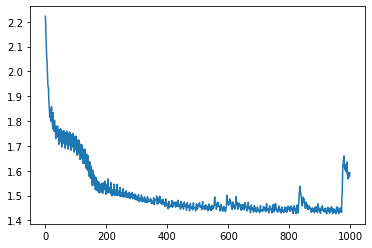

In [19]:
plt.plot(losses)

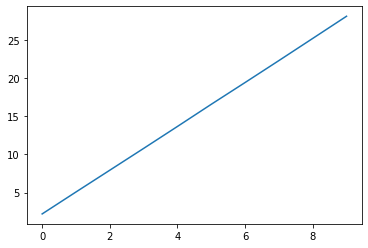

In [20]:
plt.plot(np.cumsum(ts))

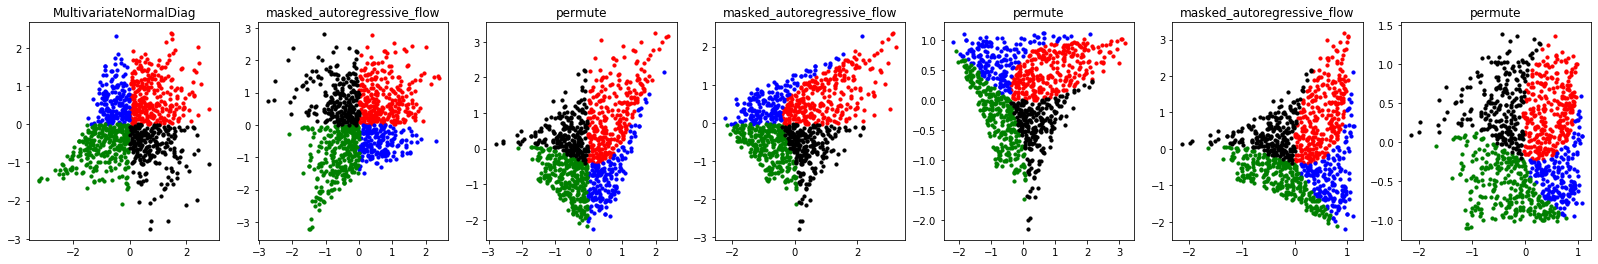

In [21]:
_ = visualize_flow(test_flow.flow)

## Examples 

### Flow for Coupled Gaussian 

In [22]:
cg_flow = InvertibleFlow()
_ = cg_flow(tf.constant([0., 0.]))
cg_flow.summary()

Model: "invertible_flow_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 69,648
Trainable params: 69,648
Non-trainable params: 0
_________________________________________________________________


In [23]:
losses, ts = train_flow(cg_flow, cg_data_iterator)

Iter  0  -  loss =  28.455711  avg_iter_time =  0.02073795795440674  total_time =   2.073795795440674
Iter  100  -  loss =  4.5153174  avg_iter_time =  0.02973567247390747  total_time =   5.047363042831421
Iter  200  -  loss =  4.2645545  avg_iter_time =  0.028881032466888428  total_time =   7.935466289520264
Iter  300  -  loss =  4.2144456  avg_iter_time =  0.028712120056152344  total_time =   10.806678295135498
Iter  400  -  loss =  4.21769  avg_iter_time =  0.029700140953063964  total_time =   13.776692390441895
Iter  500  -  loss =  4.310273  avg_iter_time =  0.028954315185546874  total_time =   16.672123908996582
Iter  600  -  loss =  4.1996346  avg_iter_time =  0.02892582893371582  total_time =   19.564706802368164
Iter  700  -  loss =  4.19733  avg_iter_time =  0.029373488426208495  total_time =   22.502055644989014
Iter  800  -  loss =  4.2891226  avg_iter_time =  0.029360413551330566  total_time =   25.43809700012207
Iter  900  -  loss =  4.189545  avg_iter_time =  0.028595046

Train Time =  28.2976016998291  seconds


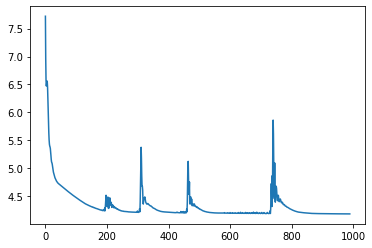

In [24]:
print("Train Time = ", np.sum(ts), " seconds")
plt.plot(losses[10:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f89c66a20>,
      dtype=object)

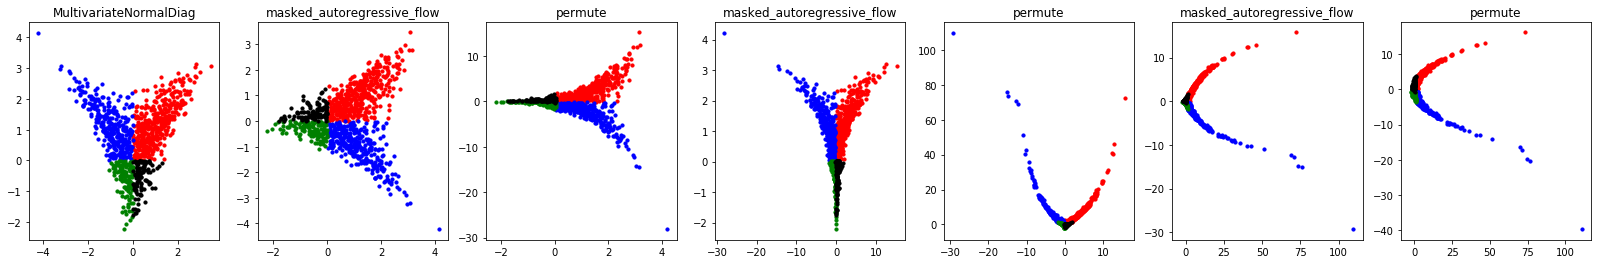

In [25]:
_ = visualize_flow(cg_flow.flow)

### Flow for two moons

In [26]:
tm_flow = InvertibleFlow()
_ = tm_flow(tf.constant([0., 0.]))
tm_flow.summary()

Model: "invertible_flow_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 69,648
Trainable params: 69,648
Non-trainable params: 0
_________________________________________________________________


In [27]:
losses, ts = train_flow(tm_flow, moons_data_iterator)

Iter  0  -  loss =  2.8283508  avg_iter_time =  0.01973674535751343  total_time =   1.9736745357513428
Iter  100  -  loss =  2.046052  avg_iter_time =  0.02875431776046753  total_time =   4.849106311798096
Iter  200  -  loss =  1.7385275  avg_iter_time =  0.029167823791503907  total_time =   7.765888690948486
Iter  300  -  loss =  1.5359282  avg_iter_time =  0.02953383207321167  total_time =   10.719271898269653
Iter  400  -  loss =  1.4512012  avg_iter_time =  0.02874536991119385  total_time =   13.593808889389038
Iter  500  -  loss =  1.3688974  avg_iter_time =  0.02843783617019653  total_time =   16.43759250640869
Iter  600  -  loss =  1.32496  avg_iter_time =  0.028516993522644044  total_time =   19.289291858673096
Iter  700  -  loss =  1.2807479  avg_iter_time =  0.02932915210723877  total_time =   22.222207069396973
Iter  800  -  loss =  1.2508442  avg_iter_time =  0.02927309036254883  total_time =   25.149516105651855
Iter  900  -  loss =  1.2219355  avg_iter_time =  0.029390304

Train Time =  28.08854651451111  seconds


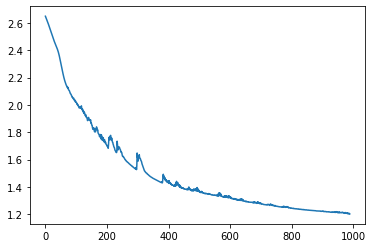

In [28]:
print("Train Time = ", np.sum(ts), " seconds")
plt.plot(losses[10:])

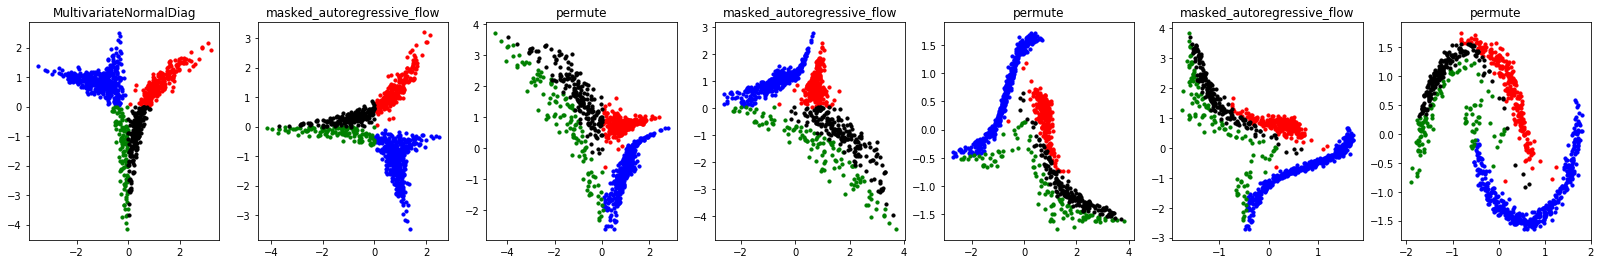

In [29]:
_ = visualize_flow(tm_flow.flow)

### Flow with Batch Normalization 
